In [33]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [6]:

DATA_PATH = "..\\data\\plagiarism_dataset.csv"
MODEL_NAME = "all-mpnet-base-v2"
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv(DATA_PATH)
df["label"] = df["label"].astype(int)


In [7]:
train_df,test_df  = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42 )

In [11]:
train_df.head()

,text1,text2,label
326742,A young child looks at the camera as a woman i...,A man flies to Mars tomorrow.,0
184420,A man standing on scaffolding next to a white ...,A man standing near a white ladder.,1
265758,Several dogs are walking around on a brick str...,A group of dogs are running on a brick street,0
362068,A woman in a red tunic plays guitar in front o...,A woman is performing music.,1
166361,Man in a red shirt riding a trick bicycle on o...,a woman riding in her car,0


In [14]:
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

c:\Python310\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
def encode_sentences(sentences):
    embeddings = []
    for i in range(0, len(sentences), BATCH_SIZE):
        batch = sentences[i:i+BATCH_SIZE]
        emb = model.encode(batch, convert_to_tensor=True, device=DEVICE)
        embeddings.append(emb)
    return torch.cat(embeddings)

In [26]:
#a sentence in the train dataset
print(train_df["text1"][0])
print(train_df["text2"][0])
print(train_df["label"][0])

A person on a horse jumps over a broken down airplane.
A person is at a diner, ordering an omelette.
0


In [27]:
print(train_df["text1"][1])
print(train_df["text2"][1])
print(train_df["label"][1])

A person on a horse jumps over a broken down airplane.
A person is outdoors, on a horse.
1


In [29]:
print(encode_sentences(train_df["text1"][0]))
print(encode_sentences(train_df["text2"][0]))

tensor([-0.0211,  0.0151, -0.0069,  ..., -0.0289, -0.0214, -0.0059],
       device='cuda:0')
tensor([ 0.0502,  0.0234,  0.0250,  ...,  0.0006, -0.0099,  0.0057],
       device='cuda:0')


In [30]:
print(encode_sentences(train_df["text1"][1]))
print(encode_sentences(train_df["text2"][1]))

tensor([-0.0211,  0.0151, -0.0069,  ..., -0.0289, -0.0214, -0.0059],
       device='cuda:0')
tensor([ 0.0063,  0.0323,  0.0110,  ..., -0.0006, -0.0507, -0.0187],
       device='cuda:0')


In [34]:
def plot_tensor(tensor_data):
    tensor_cpu = tensor_data.cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.plot(tensor_cpu)
    plt.title("1D Tensor Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


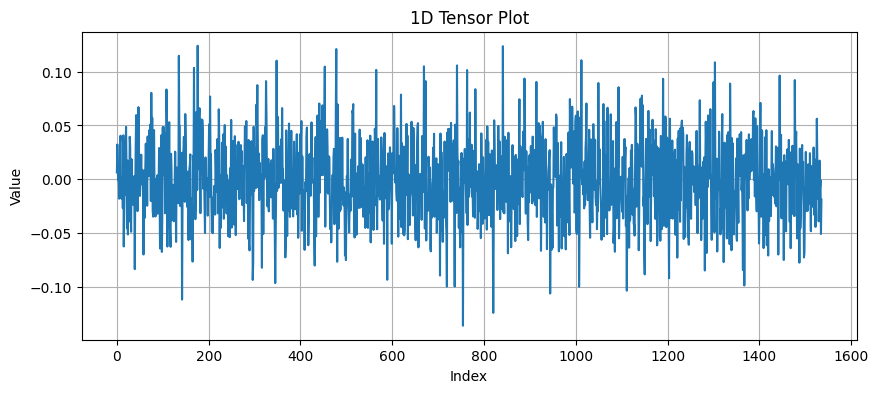

In [35]:
plot_tensor(encode_sentences(train_df["text2"][1]))

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# Move to CPU

text1_np = encode_sentences(train_df["text1"][0]).cpu().numpy()
text2_np = encode_sentences(train_df["text2"][0]).cpu().numpy()
labels_np = labels.cpu().numpy()

# Compute cosine similarity
similarities = np.array([
    cosine_similarity([t1], [t2])[0][0]
    for t1, t2 in zip(text1_np, text2_np)
])

# Plot
plt.figure(figsize=(10, 5))
plt.hist(similarities[labels_np == 1], bins=50, alpha=0.6, label="Copied (label=1)", color='green')
plt.hist(similarities[labels_np == 0], bins=50, alpha=0.6, label="Not Copied (label=0)", color='red')
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.title("Cosine Similarity Between Text1 and Text2")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
text1_np = encode_sentences(train_df["text1"][0]).cpu().numpy()
text2_np = encode_sentences(train_df["text2"][0]).cpu().numpy()

In [60]:
print(text1_np,text1_np.shape)

[-0.02113474  0.0150687  -0.00687373 ... -0.02889436 -0.02138986
 -0.00587552] (1536,)


In [61]:
print(text2_np,text2_np.shape)

[ 0.05024489  0.02335338  0.0250229  ...  0.00062091 -0.00994329
  0.00569152] (1536,)


In [46]:
diff_vectors = text1_np-text2_np

In [51]:
diff_vectors.shape

(1, 1536)

In [49]:
if diff_vectors.shape[0] < 2:
    print("Need at least 2 sentence pairs to perform PCA.")
else:
    pca = PCA(n_components=2)
    components = pca.fit_transform(diff_vectors)

    plt.figure(figsize=(8, 6))
    plt.scatter(components[labels == 1, 0], components[labels == 1, 1], label='Copied', alpha=0.5, c='green')
    plt.scatter(components[labels == 0, 0], components[labels == 0, 1], label='Not Copied', alpha=0.5, c='red')
    plt.title("PCA of Embedding Differences (Text1 - Text2)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()


Need at least 2 sentence pairs to perform PCA.


In [44]:
from sklearn.decomposition import PCA

diff_vectors = text1_np - text2_np
print(diff_vectors)


[-0.07137963 -0.00828468 -0.03189663 ... -0.02951527 -0.01144657
 -0.01156704]


In [45]:
pca = PCA(n_components=2)
components = pca.fit_transform(diff_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(components[labels == 1, 0], components[labels == 1, 1], label='Copied', alpha=0.5, c='green')
plt.scatter(components[labels == 0, 0], components[labels == 0, 1], label='Not Copied', alpha=0.5, c='red')
plt.title("PCA of Embedding Differences (Text1 - Text2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[-0.07137963 -0.00828468 -0.03189663 ... -0.02951527 -0.01144657
 -0.01156704].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(components[labels_np == 1, 0], components[labels_np == 1, 1], label='Copied', alpha=0.5, c='green')
plt.scatter(components[labels_np == 0, 0], components[labels_np == 0, 1], label='Not Copied', alpha=0.5, c='red')
plt.title("PCA of Embedding Differences (Text1 - Text2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Assume emb1 and emb2 are 1D vectors (e.g., shape [768])
sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import torch


In [65]:

# # Load dataset
df = pd.read_csv("..\\data\\test.csv")
# print("Data loaded:", df.shape)

# # Load model
# model = SentenceTransformer("all-MiniLM-L6-v2")

# # Encode sentences
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print("Using device:", device)

text1_emb = model.encode(df['text1'].tolist(), batch_size=32, show_progress_bar=True, device=DEVICE)
text2_emb = model.encode(df['text2'].tolist(), batch_size=32, show_progress_bar=True, device=DEVICE)

text1_emb = np.array(text1_emb)
text2_emb = np.array(text2_emb)
labels = df['label'].values


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

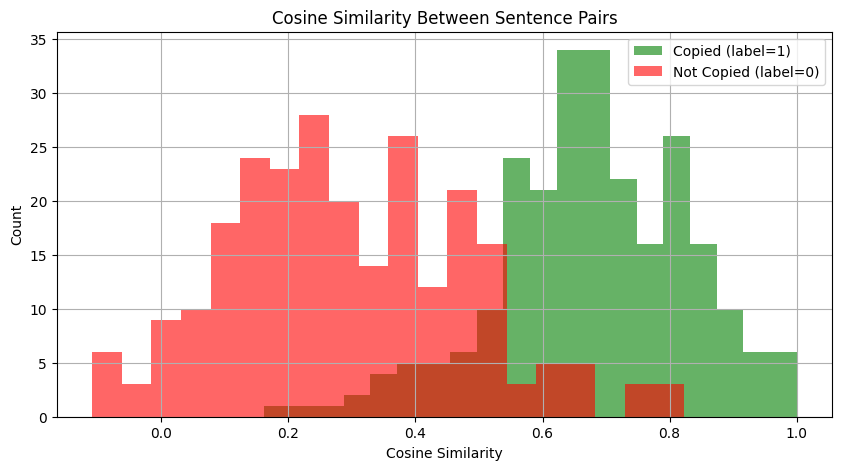

In [70]:
# Cosine similarity function
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

similarities = np.array([cosine_sim(a, b) for a, b in zip(text1_emb, text2_emb)])

plt.figure(figsize=(10, 5))
plt.hist(similarities[labels == 1], bins=20, alpha=0.6, label="Copied (label=1)", color='green')
plt.hist(similarities[labels == 0], bins=20, alpha=0.6, label="Not Copied (label=0)", color='red')
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.title("Cosine Similarity Between Sentence Pairs")
plt.legend()
plt.grid(True)
plt.show()


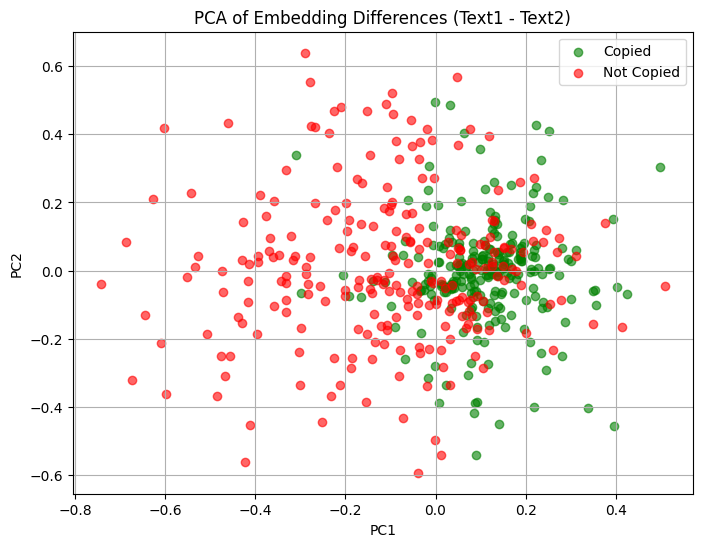

In [ ]:

diff_vectors = text1_emb - text2_emb
pca = PCA(n_components=2)
components = pca.fit_transform(diff_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(components[labels == 1, 0], components[labels == 1, 1], label='Copied', alpha=0.6, c='green')
plt.scatter(components[labels == 0, 0], components[labels == 0, 1], label='Not Copied', alpha=0.6, c='red')
plt.title("PCA of Embedding Differences (Text1 - Text2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


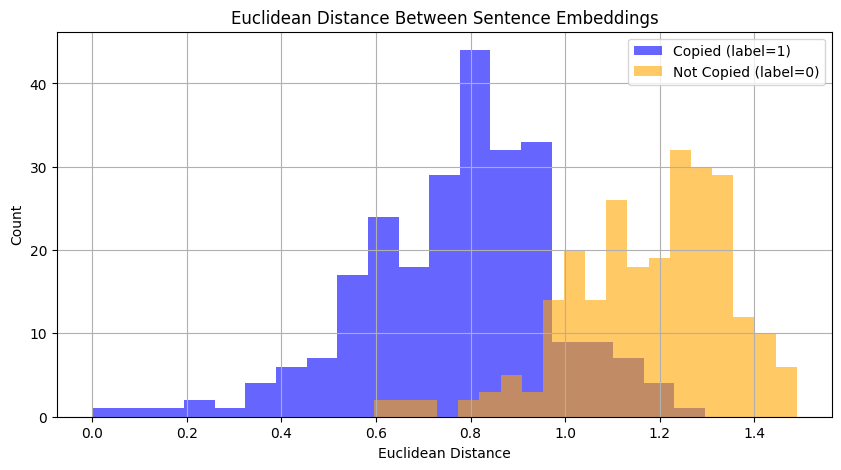

In [69]:

distances = np.linalg.norm(diff_vectors, axis=1)
plt.figure(figsize=(10, 5))
plt.hist(distances[labels == 1], bins=20, alpha=0.6, label="Copied (label=1)", color='blue')
plt.hist(distances[labels == 0], bins=20, alpha=0.6, label="Not Copied (label=0)", color='orange')
plt.xlabel("Euclidean Distance")
plt.ylabel("Count")
plt.title("Euclidean Distance Between Sentence Embeddings")
plt.legend()
plt.grid(True)
plt.show()


c:\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


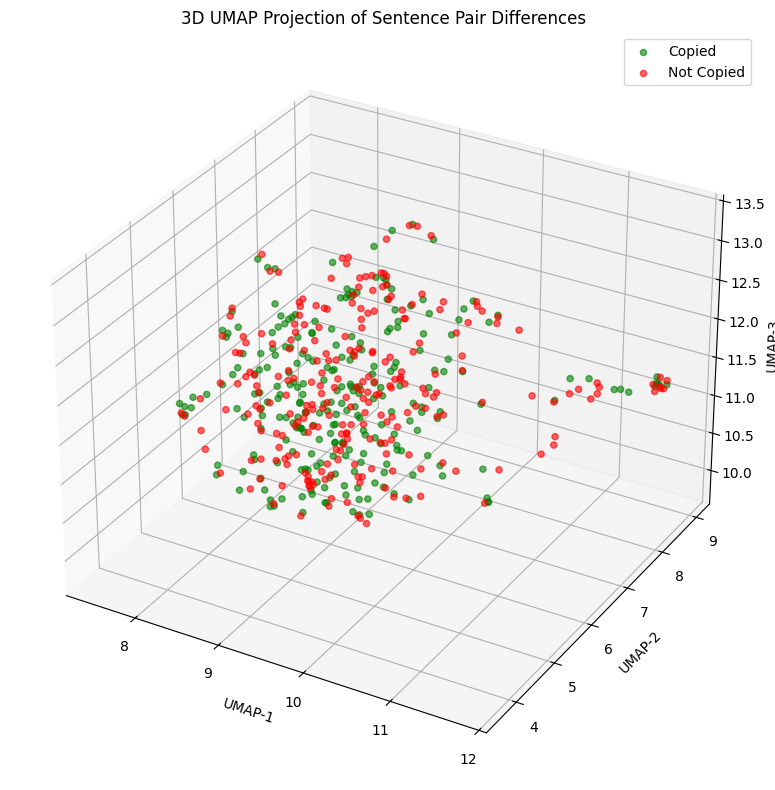

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
import numpy as np

# Assuming you have:
# diff_vectors = np.array of shape (n_samples, 1536)
# labels = np.array of shape (n_samples,) with 0 or 1

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(diff_vectors)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

copied = labels == 1
not_copied = labels == 0

ax.scatter(embedding_3d[copied, 0], embedding_3d[copied, 1], embedding_3d[copied, 2], c='green', label='Copied', alpha=0.6)
ax.scatter(embedding_3d[not_copied, 0], embedding_3d[not_copied, 1], embedding_3d[not_copied, 2], c='red', label='Not Copied', alpha=0.6)

ax.set_title("3D UMAP Projection of Sentence Pair Differences")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
ax.legend()
plt.tight_layout()
plt.show()
